In [1]:
# !pip install albumentations

# Augmentations
[torchvision.transforms](https://pytorch.org/docs/stable/torchvision/transforms.html)
- CPU
- only a few main transformations supported

[imgaug](https://github.com/aleju/imgaug)
- CPU
- can process batches
- easy to use
- simultaneous transformations for multiple targets (images, bboxes, keypoints, segmentation masks, heatmaps)
- beautiful visualization methods

[albumentations](https://github.com/albumentations-team/albumentations)
- CPU
- fast transforms
- easy to use
- easy to migrate from torchvision (direct drop-in replacement, same interface)
- simultaneous transformations for multiple targets (images, bboxes, keypoints, segmentation masks)

[Nvidia.DALI](https://github.com/NVIDIA/DALI)
- GPU
- a bit more complicated to use

In [2]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, **kwargs):
    #height, width = img.shape[:2]

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize_titles(img, bbox, title, color=BOX_COLOR, thickness=2, font_thickness = 2, font_scale=0.35, **kwargs):
    #height, width = img.shape[:2]
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, 
                     font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, mask=mask, bboxes=bboxes, category_id=categories)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        visualize_bbox(image, bbox, **kwargs)

    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)

    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)

    
    if mask is None:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))
        
        ax[0].imshow(image)
        ax[0].set_title('Original image')
        
        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16))
        
        if len(mask.shape) != 3:
            mask = label2rgb(mask, bg_label=0)            
            mask_aug = label2rgb(augmented['mask'], bg_label=0)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask_aug = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2RGB)
            
        ax[0, 0].imshow(image)
        ax[0, 0].set_title('Original image')
        
        ax[0, 1].imshow(image_aug)
        ax[0, 1].set_title('Augmented image')
        
        ax[1, 0].imshow(mask, interpolation='nearest')
        ax[1, 0].set_title('Original mask')

        ax[1, 1].imshow(mask_aug, interpolation='nearest')
        ax[1, 1].set_title('Augmented mask')

    f.tight_layout()
    if filename is not None:
        f.savefig(filename)
        
    return augmented['image'], augmented['mask'], augmented['bboxes']

def find_in_dir(dirname):
    return [os.path.join(dirname, fname) for fname in sorted(os.listdir(dirname))]

In [3]:
random.seed(42)
image = cv2.imread('images/parrot.jpg')

light = A.Compose([
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),
    A.CLAHE(p=1),
], p=1)

medium = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)


strong = A.Compose([
    A.ChannelShuffle(p=1),
], p=1)

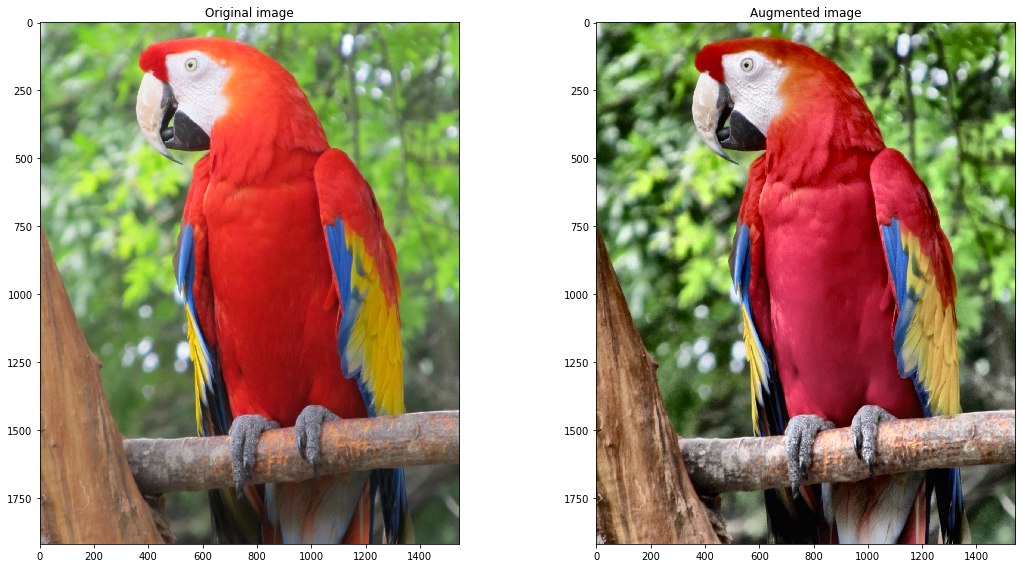

In [4]:
r = augment_and_show(light, image)

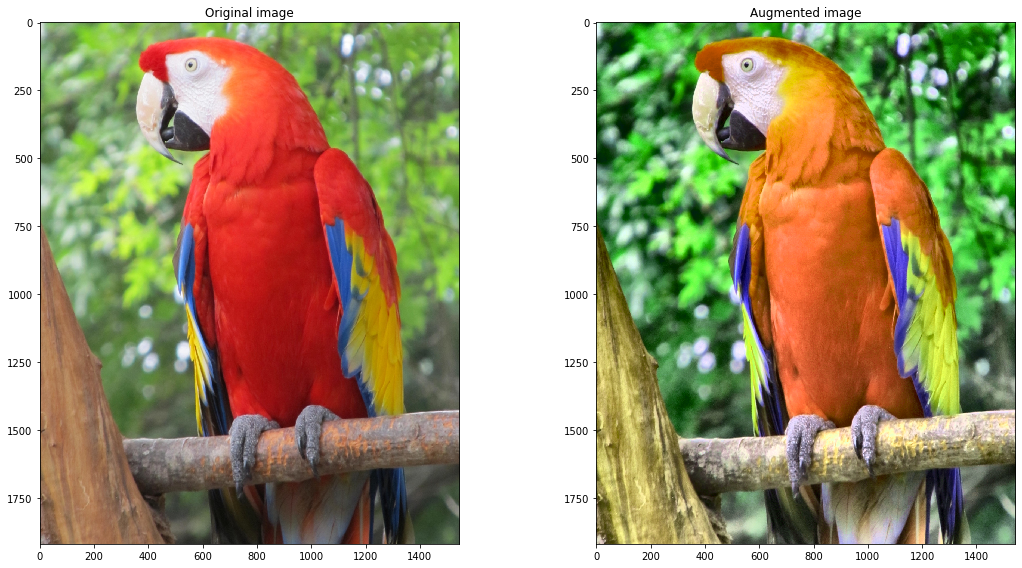

In [5]:
r = augment_and_show(medium, image)

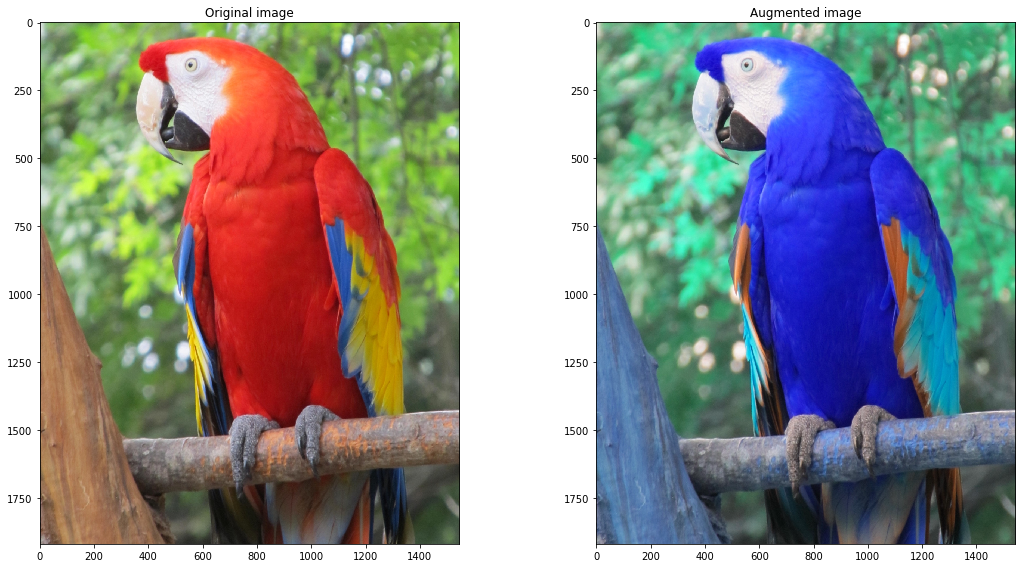

In [8]:
r = augment_and_show(strong, image)

See more examples for other use cases [in original notebook](https://github.com/albumentations-team/albumentations/blob/master/notebooks/showcase.ipynb)

In general albumentation use is quite straightforward:
```python
import albumentations as A
from albumentations.pytorch import ToTensor

# assuming your input image is np.uint8 or np.float32 images
train_transforms = A.Compose([
    # Define your augmentation pipeline
    A.RGBShift(),
    A.InvertImg(),
    A.Blur(),
    A.GaussNoise(),
    A.Flip(),
    A.RandomRotate90(),
    A.RandomSizedCrop((512 - 100, 512 + 100), 512, 512),
    ...
    # Do not forget to normalize
    A.Normalize(...), #(Divide pixel values by 255 = 2**8 - 1, subtract mean per channel and divide by std per channel.)
    ToTensor()
])

test_transforms = A.Compose([
    # No augmentations
    
    # Do not forget to normalize
    A.Normalize(...),
    ToTensor()
])
```

If you need to process bboxes, segmaps, keypoints or multiple images with the same transformation
```python
transform = A.Compose(
    transformations, 
    p=1, 
    additional_targets={
        'image1': 'image',
        'image2': 'image',
        ...
        'imageN': 'image',

        'bboxes1': 'bboxes',  # bboxes1 is [bbox1, bbox2, bbox3, ...] - list of bboxes
        'bboxes1': 'bboxes',  # bboxes2 is [bbox1, bbox2, bbox3, ...] - another list of bboxes
        ...
        'bboxesM': 'bboxes',

        'keypoints1': 'keypoints',
        'keypoints2': 'keypoints',
        ...
        'keypointsK': 'keypoints',

        'mask1': 'mask',
        'mask2': 'mask',
        ...
        'maskL': 'mask'
    })
    
# when apply
transformed = transform(image1=image1, image2=image2, ...)
```